# Nokappa v3 Holdout Evaluation: Constant vs Cos300 vs Clip

All three configs use **non-centered parameterization** with **kappa=1 (fixed)**, W=1e-4, 300 epochs.  
- **Constant**: LR=0.1 constant  
- **Cos300**: LR=0.1 → 0.001 cosine annealing  
- **Clip**: LR=0.1 constant, grad_clip=5.0  

Trained on batches 20–29 (200k–300k). Holdout: 390k–400k.

**Pipeline:**
1. Load & pool parameters from 10 training batches per config
2. Diagnostic summary: gamma magnitude, top features, psi shifts
3. Holdout prediction (fit δ on held-out data)
4. Holdout loss + AUC comparison

In [ ]:
import numpy as np
import pandas as pd
import torch
import glob
import os
import sys
import gc
import warnings
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib

REPO_ROOT = Path('/Users/sarahurbut/aladynoulli2')
sys.path.insert(0, str(REPO_ROOT / 'claudefile'))
sys.path.insert(0, str(REPO_ROOT / 'claudefile' / 'aws_offsetmaster'))
sys.path.insert(0, str(REPO_ROOT / 'pyScripts'))

from nokappa_prediction_utils import fit_and_extract_pi
from fig5utils import evaluate_major_diseases_wsex_with_bootstrap_dynamic_from_pi

warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# ---------- Paths ----------
DROPBOX = Path('/Users/sarahurbut/Library/CloudStorage/Dropbox')
DATA_DIR = Path('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/')
COV_PATH = '/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/baselinagefamh_withpcs.csv'
PCE_PATH = '/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/pce_prevent_full.csv'

# Config dirs (trained on batches 20-29)
CONFIGS = {
    'constant': {
        'dir': DROPBOX / 'nokappa_v3_W1e-4_b20_30',
        'pattern': '*REPARAM_NOKAPPA_W0.0001_batch_*.pt',
        'color': '#1f77b4',
    },
    'cos300': {
        'dir': DROPBOX / 'nokappa_v3_cos300_b20_30',
        'pattern': '*REPARAM_NOKAPPA_COS300_W0.0001_batch_*.pt',
        'color': '#d62728',
    },
    'clip': {
        'dir': DROPBOX / 'nokappa_v3_clip_b20_30',
        'pattern': '*REPARAM_NOKAPPA_CLIP_W0.0001_batch_*.pt',
        'color': '#2ca02c',
    },
}

# Holdout range (no overlap with training 200k-300k)
HOLDOUT_START = 390000
HOLDOUT_END = 400000

# PRS feature names
prs_df = pd.read_csv('/Users/sarahurbut/aladynoulli2/prs_names.csv')
PRS_NAMES = list(prs_df.columns) + list(prs_df.iloc[:, 0].values)
FEATURE_NAMES = PRS_NAMES + ['Sex'] + [f'PC{i}' for i in range(1, 11)]
print(f'{len(PRS_NAMES)} PRS features + Sex + 10 PCs = {len(FEATURE_NAMES)} total features')

36 PRS features + Sex + 10 PCs = 47 total features


## 1. Load & Pool Parameters

In [ ]:
def load_all_checkpoints(ckpt_dir, pattern):
    """Load phi, psi, kappa, gamma from all batch checkpoints."""
    files = sorted(glob.glob(os.path.join(str(ckpt_dir), pattern)))
    print(f'Found {len(files)} files in {ckpt_dir}')

    all_phi, all_psi, all_kappa, all_gamma = [], [], [], []
    batch_stats = []

    for fp in files:
        ckpt = torch.load(fp, weights_only=False)

        def _get(name):
            if 'model_state_dict' in ckpt and name in ckpt['model_state_dict']:
                return ckpt['model_state_dict'][name]
            return ckpt.get(name)

        phi = _get('phi')
        psi = _get('psi')
        gamma = _get('gamma')
        kappa = _get('kappa')

        if phi is None or gamma is None:
            print(f'  Skip {Path(fp).name}: missing phi or gamma')
            continue

        phi_np = phi.detach().cpu().numpy() if torch.is_tensor(phi) else np.array(phi)
        psi_np = psi.detach().cpu().numpy() if torch.is_tensor(psi) else (np.array(psi) if psi is not None else None)
        gamma_np = gamma.detach().cpu().numpy() if torch.is_tensor(gamma) else np.array(gamma)
        kappa_val = float(kappa) if kappa is not None else 1.0

        all_phi.append(phi_np)
        all_psi.append(psi_np)
        all_kappa.append(kappa_val)
        all_gamma.append(gamma_np)
        batch_stats.append({'mean_abs_gamma': np.abs(gamma_np).mean()})

    print(f'Loaded {len(all_phi)} checkpoints')
    stats_df = pd.DataFrame(batch_stats)
    return all_phi, all_psi, all_kappa, all_gamma, stats_df


def pool_params(all_phi, all_psi, all_kappa, all_gamma):
    phi = np.mean(np.stack(all_phi), axis=0)
    kappa = float(np.mean(all_kappa))
    gamma = np.mean(np.stack(all_gamma), axis=0)
    psi_valid = [p for p in all_psi if p is not None]
    psi = np.mean(np.stack(psi_valid), axis=0) if psi_valid else None
    return phi, psi, kappa, gamma


# Load all configs
loaded = {}  # config_name -> (all_phi, all_psi, all_kappa, all_gamma, stats_df)
pooled = {}  # config_name -> (phi, psi, kappa, gamma)

for name, cfg in CONFIGS.items():
    print(f'\n=== {name.upper()} ===')
    if not cfg['dir'].exists():
        print(f'  Directory not found: {cfg["dir"]} — SKIPPING')
        continue
    all_phi, all_psi, all_kappa, all_gamma, stats = load_all_checkpoints(cfg['dir'], cfg['pattern'])
    if len(all_phi) == 0:
        print(f'  No valid checkpoints — SKIPPING')
        continue
    loaded[name] = (all_phi, all_psi, all_kappa, all_gamma, stats)
    phi, psi, kappa, gamma = pool_params(all_phi, all_psi, all_kappa, all_gamma)
    pooled[name] = (phi, psi, kappa, gamma)
    print(f'  Pooled: phi {phi.shape}, gamma {gamma.shape}, kappa={kappa:.4f}')
    print(f'  mean|gamma| = {np.abs(gamma).mean():.4f}')

print(f'\nLoaded configs: {list(pooled.keys())}')


=== CONSTANT ===
Found 10 files in /Users/sarahurbut/Library/CloudStorage/Dropbox/nokappa_v3_W1e-4_b20_30
Loaded 10 checkpoints
  Pooled: phi (21, 348, 52), gamma (47, 21), kappa=1.0000
  mean|gamma| = 0.1354

=== COS300 ===
Found 10 files in /Users/sarahurbut/Library/CloudStorage/Dropbox/nokappa_v3_cos300_b20_30
Loaded 10 checkpoints
  Pooled: phi (21, 348, 52), gamma (47, 21), kappa=1.0000
  mean|gamma| = 0.1248

=== CLIP ===
Found 10 files in /Users/sarahurbut/Library/CloudStorage/Dropbox/nokappa_v3_clip_b20_30
Loaded 10 checkpoints
  Pooled: phi (21, 348, 52), gamma (47, 21), kappa=1.0000
  mean|gamma| = 0.1354

Loaded configs: ['constant', 'cos300', 'clip']


## 2. Diagnostic Summary

### 2a. Gamma magnitude per batch

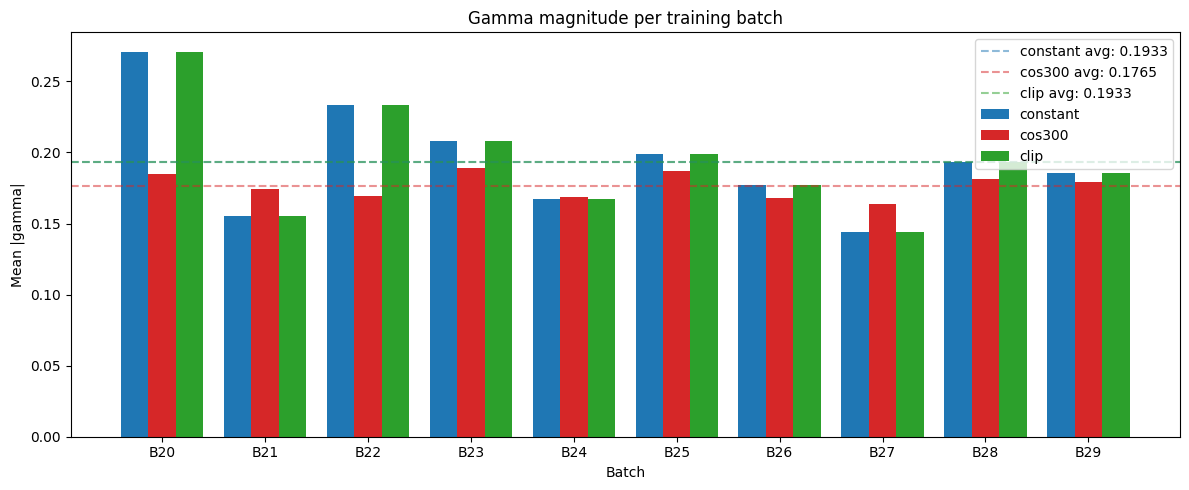

In [ ]:
n_configs = len(loaded)
fig, ax = plt.subplots(figsize=(12, 5))
n_batches = max(len(v[4]) for v in loaded.values())
x = np.arange(n_batches)
w = 0.8 / n_configs

for i, (name, (_, _, _, _, stats)) in enumerate(loaded.items()):
    color = CONFIGS[name]['color']
    vals = stats['mean_abs_gamma'].values
    offset = (i - n_configs / 2 + 0.5) * w
    ax.bar(x[:len(vals)] + offset, vals, w, label=name, color=color)
    ax.axhline(vals.mean(), color=color, ls='--', alpha=0.5,
               label=f'{name} avg: {vals.mean():.4f}')

ax.set_xlabel('Batch')
ax.set_ylabel('Mean |gamma|')
ax.set_title('Gamma magnitude per training batch')
ax.set_xticks(x)
ax.set_xticklabels([f'B{i+20}' for i in range(n_batches)])
ax.legend()
plt.tight_layout()
plt.show()

### 2b. Top features per signature (|gamma|)

In [ ]:
def top_features_per_sig(gamma_pooled, feature_names, n_top=5):
    """For each signature k, show top features by |gamma|."""
    P, K = gamma_pooled.shape
    rows = []
    for k in range(K):
        weights = gamma_pooled[:, k]
        order = np.argsort(-np.abs(weights))
        top_feats = []
        for idx in order[:n_top]:
            name = feature_names[idx] if idx < len(feature_names) else f'Feat{idx}'
            top_feats.append(f'{name} ({weights[idx]:+.3f})')
        rows.append({
            'sig': k,
            'mean_abs': np.abs(weights).mean(),
            'top_features': ', '.join(top_feats)
        })
    return pd.DataFrame(rows)


for name, (phi, psi, kappa, gamma) in pooled.items():
    print(f'\n=== {name.upper()}: Top 5 features per signature ===')
    df_top = top_features_per_sig(gamma, FEATURE_NAMES)
    for _, row in df_top.iterrows():
        print(f'  Sig {row["sig"]:2d} (|γ|={row["mean_abs"]:.4f}): {row["top_features"]}')


=== CONSTANT: Top 5 features per signature ===
  Sig  0 (|γ|=0.1055): Sex (+0.731), AF (+0.342), PC3 (+0.237), ISS (+0.234), T2D (+0.230)
  Sig  1 (|γ|=0.0764): BMI (+0.231), Sex (+0.221), T2D (+0.219), ISS (+0.218), AST (+0.207)
  Sig  2 (|γ|=0.0823): Sex (+0.335), T2D (+0.222), AST (+0.211), ISS (+0.197), BMI (+0.175)
  Sig  3 (|γ|=0.0860): Sex (+0.572), AST (+0.204), T2D (+0.203), ISS (+0.202), BMI (+0.187)
  Sig  4 (|γ|=0.2471): Sex (+3.071), PC1 (-2.210), PC2 (+0.455), PC4 (+0.444), AST (+0.318)
  Sig  5 (|γ|=0.1039): Sex (+0.744), CAD (+0.289), T2D (+0.247), HT (+0.240), ISS (+0.198)
  Sig  6 (|γ|=0.2280): PC1 (-4.154), PC2 (+1.775), Sex (-0.624), BC (+0.463), PC3 (-0.310)
  Sig  7 (|γ|=0.0859): Sex (+0.298), HT (+0.250), AST (+0.235), T2D (+0.225), ISS (+0.216)
  Sig  8 (|γ|=0.1020): Sex (-1.608), PC1 (+0.209), T2D (+0.204), AST (+0.178), HT (+0.159)
  Sig  9 (|γ|=0.1352): PC2 (+1.458), PC3 (+0.932), PC1 (-0.282), Sex (+0.281), T2D (+0.231)
  Sig 10 (|γ|=0.0908): PC1 (+0.310), 

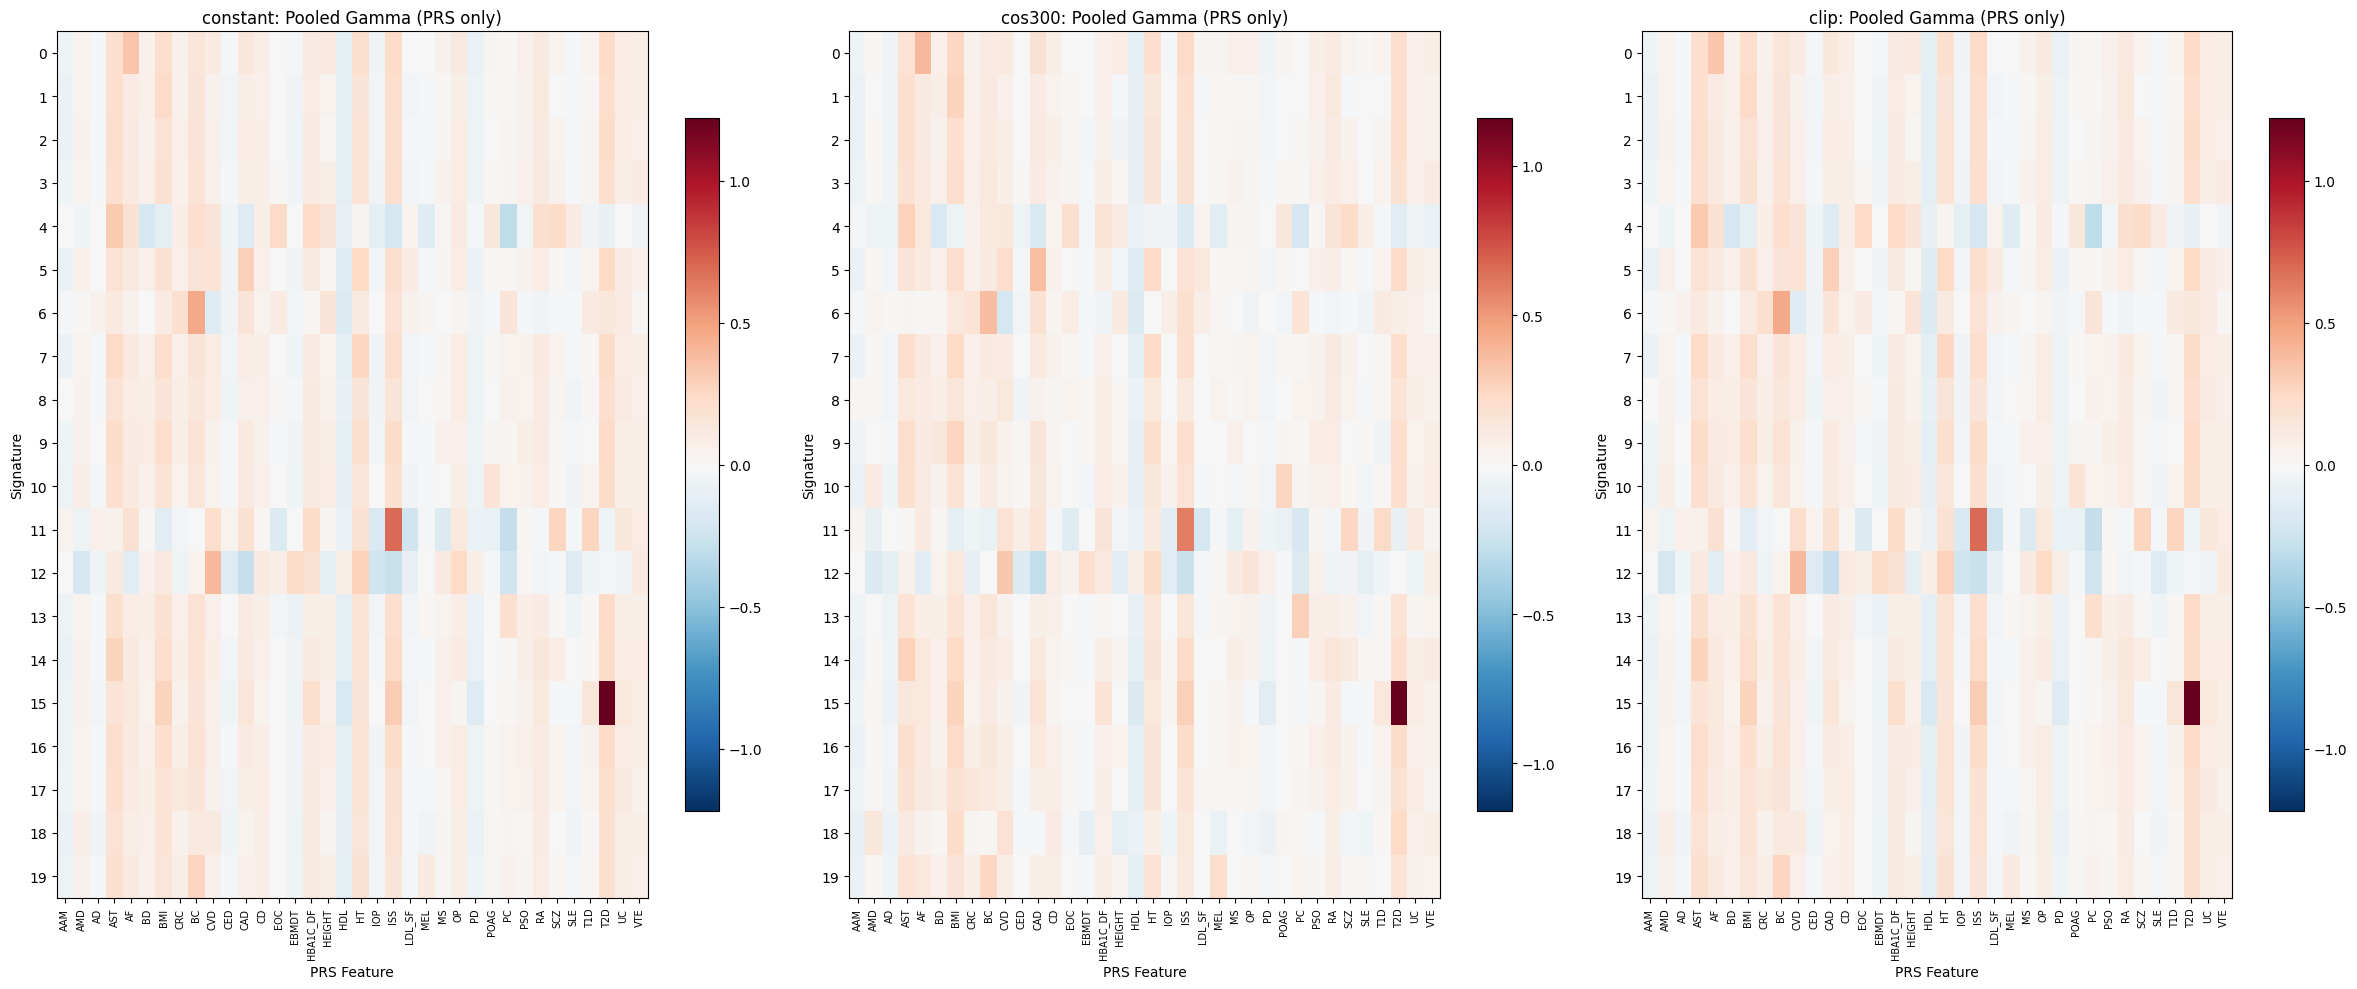

In [ ]:
# Gamma heatmap (PRS only, first 36 features, exclude healthy sig)
n_prs = 36
n_plots = len(pooled)
fig, axes = plt.subplots(1, n_plots, figsize=(8 * n_plots, 10))
if n_plots == 1:
    axes = [axes]

for ax, (name, (phi, psi, kappa, gamma)) in zip(axes, pooled.items()):
    g = gamma[:n_prs, :20]  # PRS x disease sigs
    vmax = np.abs(g).max()
    im = ax.imshow(g.T, aspect='auto', cmap='RdBu_r', vmin=-vmax, vmax=vmax)
    ax.set_xlabel('PRS Feature')
    ax.set_ylabel('Signature')
    ax.set_title(f'{name}: Pooled Gamma (PRS only)')
    ax.set_xticks(range(n_prs))
    ax.set_xticklabels(PRS_NAMES, rotation=90, fontsize=7)
    ax.set_yticks(range(20))
    plt.colorbar(im, ax=ax, shrink=0.8)

plt.tight_layout()
plt.show()

### 2c. Psi shifts from initialization

In [ ]:
# Load initial psi
initial_psi = torch.load(str(DATA_DIR / 'initial_psi_400k.pt'), weights_only=False)
init_psi_np = initial_psi.detach().cpu().numpy() if torch.is_tensor(initial_psi) else np.array(initial_psi)
K_dis = 20
argmax_init = np.argmax(init_psi_np[:K_dis], axis=0)

print('Psi flips from initialization (pooled):')
print(f'  (v2 nokappa reference: nolr=0, reparam_v1=13, nokappa_v2=2)\n')

for name, (phi, psi, kappa, gamma) in pooled.items():
    if psi is None:
        print(f'  {name}: psi=None (no psi data)')
        continue
    argmax_pooled = np.argmax(psi[:K_dis], axis=0)
    flips = (argmax_init != argmax_pooled).sum()
    print(f'  {name}: {flips}/348 diseases flipped')

# Per-batch psi drift from init
print('\nPer-batch mean |psi - psi_init|:')
for name, (all_phi, all_psi, all_kappa, all_gamma, _) in loaded.items():
    diffs = []
    for psi_b in all_psi:
        if psi_b is not None:
            diff = np.abs(psi_b[:K_dis] - init_psi_np[:K_dis]).mean()
            diffs.append(diff)
    print(f'  {name}: mean={np.mean(diffs):.6f}  (per batch: {["{:.4f}".format(d) for d in diffs]})')

Psi flips from initialization (pooled):
  (v2 nokappa reference: nolr=0, reparam_v1=13, nokappa_v2=2)

  constant: 8/348 diseases flipped
  cos300: 0/348 diseases flipped
  clip: 8/348 diseases flipped

Per-batch mean |psi - psi_init|:
  constant: mean=0.992974  (per batch: ['0.9908', '1.0089', '0.9684', '0.9760', '1.0103', '0.9838', '0.9987', '1.0006', '1.0060', '0.9863'])
  cos300: mean=0.710905  (per batch: ['0.7060', '0.7207', '0.6987', '0.7017', '0.7347', '0.7054', '0.7184', '0.7195', '0.7096', '0.6944'])
  clip: mean=0.992974  (per batch: ['0.9908', '1.0089', '0.9684', '0.9760', '1.0103', '0.9838', '0.9987', '1.0006', '1.0060', '0.9863'])


In [ ]:
# Cross-config correlations (pairwise)
config_names = list(pooled.keys())
for param_name in ['phi', 'psi', 'gamma']:
    idx = {'phi': 0, 'psi': 1, 'gamma': 3}[param_name]
    print(f'\n{param_name} correlations (pairwise):')
    for i in range(len(config_names)):
        for j in range(i + 1, len(config_names)):
            a = pooled[config_names[i]][idx]
            b = pooled[config_names[j]][idx]
            if a is not None and b is not None:
                corr = np.corrcoef(a.flatten(), b.flatten())[0, 1]
                print(f'  {config_names[i]} vs {config_names[j]}: {corr:.4f}')


phi correlations (pairwise):
  constant vs cos300: 0.9717
  constant vs clip: 1.0000
  cos300 vs clip: 0.9717

psi correlations (pairwise):
  constant vs cos300: 0.9362
  constant vs clip: 1.0000
  cos300 vs clip: 0.9362

gamma correlations (pairwise):
  constant vs cos300: 0.8733
  constant vs clip: 1.0000
  cos300 vs clip: 0.8733


## 3. Holdout Prediction

Fix φ, ψ, γ (pooled from training). Fit δ on holdout (390k–400k). Extract π.

In [ ]:
# Load holdout data
print('Loading data...')
Y_full = torch.load(str(DATA_DIR / 'Y_tensor.pt'), weights_only=False)
E_full = torch.load(str(DATA_DIR / 'E_enrollment_full.pt'), weights_only=False)
G_full = torch.load(str(DATA_DIR / 'G_matrix.pt'), weights_only=False)
essentials = torch.load(str(DATA_DIR / 'model_essentials.pt'), weights_only=False)
disease_names = essentials['disease_names']
refs = torch.load(str(DATA_DIR / 'reference_trajectories.pt'), weights_only=False)
signature_refs = refs['signature_refs']
del refs
prevalence_t = torch.load(str(DATA_DIR / 'prevalence_t_corrected.pt'), weights_only=False)

# Slice holdout
idx = list(range(HOLDOUT_START, HOLDOUT_END))
Y_holdout = Y_full[idx]
E_holdout = E_full[idx]
G_holdout = G_full[idx]
del Y_full, E_full, G_full
gc.collect()

# Add sex + PCs to G
fh = pd.read_csv(COV_PATH)
sex = fh['Sex'].map({'Female': 0, 'Male': 1}).astype(int).values if 'Sex' in fh.columns else fh['sex'].values
sex_h = sex[HOLDOUT_START:HOLDOUT_END]
pc_cols = [f'f.22009.0.{i}' for i in range(1, 11)]
pcs = fh.iloc[HOLDOUT_START:HOLDOUT_END][pc_cols].values
G_with_sex = np.column_stack([G_holdout, sex_h, pcs])

# PCE data for AUC
pce_df = pd.read_csv(PCE_PATH).iloc[HOLDOUT_START:HOLDOUT_END].reset_index(drop=True)
if 'Sex' not in pce_df.columns and 'sex' in pce_df.columns:
    pce_df['Sex'] = pce_df['sex'].map({0: 'Female', 1: 'Male'}).fillna('Unknown')
if 'sex' not in pce_df.columns and 'Sex' in pce_df.columns:
    pce_df['sex'] = pce_df['Sex'].map({'Female': 0, 'Male': 1}).fillna(-1)
if 'age' not in pce_df.columns and 'Age' in pce_df.columns:
    pce_df['age'] = pce_df['Age']

print(f'Holdout: {len(idx)} individuals ({HOLDOUT_START}-{HOLDOUT_END})')
print(f'Y: {Y_holdout.shape}, E: {E_holdout.shape}, G: {G_with_sex.shape}')

Loading data...
Holdout: 10000 individuals (390000-400000)
Y: torch.Size([10000, 348, 52]), E: torch.Size([10000, 348]), G: (10000, 47)


In [ ]:
# Fit delta on holdout for each config
holdout_results = {}  # config_name -> {'pi': ..., 'loss': ...}

for name, (phi, psi, kappa, gamma) in pooled.items():
    print(f'\n{"="*60}')
    print(f'{name.upper()}: fitting delta on holdout (200 epochs)...')
    print(f'{"="*60}')

    pi, loss = fit_and_extract_pi(
        Y_holdout, E_holdout, G_with_sex,
        phi, psi, kappa, gamma,
        signature_refs, prevalence_t, disease_names,
        num_epochs=200, learning_rate=0.1,
    )

    n_nan = torch.isnan(pi).sum().item() if torch.is_tensor(pi) else 0
    holdout_results[name] = {'pi': pi, 'loss': loss}
    print(f'  Holdout loss: {loss:.4f}  |  NaN in pi: {n_nan}')

print(f'\n{"="*60}')
print('HOLDOUT LOSS SUMMARY')
for name, data in holdout_results.items():
    print(f'  {name}: {data["loss"]:.4f}')
best = min(holdout_results.items(), key=lambda x: x[1]['loss'])
print(f'  → Best: {best[0]} (loss={best[1]["loss"]:.4f})')


CONSTANT: fitting delta on holdout (200 epochs)...
Pre-calculated phi GP loss: 26.4495
Using fixed gamma with shape: torch.Size([47, 21])
Using fixed kappa: 1.000000
Initializing delta (reparam) with 20 disease + 1 healthy
  lambda = mean(gamma) + delta (gamma in forward)


/Users/sarahurbut/aladynoulli2/claudefile/aws_offsetmaster/clust_huge_amp_fixedPhi_vectorized_fixed_gamma_fixed_kappa.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prevalence_t = torch.tensor(prevalence_t, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/claudefile/aws_offsetmaster/clust_huge_amp_fixedPhi_vectorized_fixed_gamma_fixed_kappa.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/claudefile/aws_offsetmaster/clust_huge_amp_fixedPhi_vectorized_fixed_gamma_fixed_kappa.py:129: UserWarning: To copy construct from a tensor, it is recommended to use sourceTenso

Epoch 0 (REPARAM): Loss=15.8108, LR=1.0e-01
Epoch 10 (REPARAM): Loss=81.8111, LR=9.9e-02
Epoch 20 (REPARAM): Loss=35.6794, LR=9.7e-02
Epoch 30 (REPARAM): Loss=22.2181, LR=9.4e-02
Epoch 40 (REPARAM): Loss=17.3290, LR=9.0e-02
Epoch 50 (REPARAM): Loss=15.5892, LR=8.5e-02
Epoch 60 (REPARAM): Loss=14.9038, LR=7.9e-02
Epoch 70 (REPARAM): Loss=14.5694, LR=7.2e-02
Epoch 80 (REPARAM): Loss=14.3683, LR=6.5e-02
Epoch 90 (REPARAM): Loss=14.2240, LR=5.7e-02
Epoch 100 (REPARAM): Loss=14.1102, LR=5.0e-02
Epoch 110 (REPARAM): Loss=14.0170, LR=4.2e-02
Epoch 120 (REPARAM): Loss=13.9404, LR=3.4e-02
Epoch 130 (REPARAM): Loss=13.8785, LR=2.7e-02
Epoch 140 (REPARAM): Loss=13.8299, LR=2.1e-02
Epoch 150 (REPARAM): Loss=13.7932, LR=1.5e-02
Epoch 160 (REPARAM): Loss=13.7670, LR=1.0e-02
Epoch 170 (REPARAM): Loss=13.7497, LR=6.0e-03
Epoch 180 (REPARAM): Loss=13.7394, LR=3.2e-03
Epoch 190 (REPARAM): Loss=13.7341, LR=1.5e-03
  Holdout loss: 13.7316  |  NaN in pi: 0

COS300: fitting delta on holdout (200 epochs)...


/Users/sarahurbut/aladynoulli2/claudefile/aws_offsetmaster/clust_huge_amp_fixedPhi_vectorized_fixed_gamma_fixed_kappa.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prevalence_t = torch.tensor(prevalence_t, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/claudefile/aws_offsetmaster/clust_huge_amp_fixedPhi_vectorized_fixed_gamma_fixed_kappa.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/claudefile/aws_offsetmaster/clust_huge_amp_fixedPhi_vectorized_fixed_gamma_fixed_kappa.py:129: UserWarning: To copy construct from a tensor, it is recommended to use sourceTenso

Epoch 0 (REPARAM): Loss=15.8295, LR=1.0e-01
Epoch 10 (REPARAM): Loss=78.5492, LR=9.9e-02
Epoch 20 (REPARAM): Loss=34.5988, LR=9.7e-02
Epoch 30 (REPARAM): Loss=22.1849, LR=9.4e-02
Epoch 40 (REPARAM): Loss=17.7288, LR=9.0e-02
Epoch 50 (REPARAM): Loss=16.1697, LR=8.5e-02
Epoch 51 (REPARAM): Early stop (no improvement for 50 epochs, best=15.8295 at epoch 0)
  Holdout loss: 16.0694  |  NaN in pi: 0

CLIP: fitting delta on holdout (200 epochs)...
Pre-calculated phi GP loss: 26.4495
Using fixed gamma with shape: torch.Size([47, 21])
Using fixed kappa: 1.000000
Initializing delta (reparam) with 20 disease + 1 healthy
  lambda = mean(gamma) + delta (gamma in forward)
Epoch 0 (REPARAM): Loss=15.8108, LR=1.0e-01
Epoch 10 (REPARAM): Loss=81.8111, LR=9.9e-02
Epoch 20 (REPARAM): Loss=35.6794, LR=9.7e-02
Epoch 30 (REPARAM): Loss=22.2181, LR=9.4e-02
Epoch 40 (REPARAM): Loss=17.3290, LR=9.0e-02
Epoch 50 (REPARAM): Loss=15.5892, LR=8.5e-02
Epoch 60 (REPARAM): Loss=14.9038, LR=7.9e-02
Epoch 70 (REPARAM):

## 4. AUC Comparison (Dynamic 10-Year)

In [ ]:
auc_results = {}

for name, data in holdout_results.items():
    print(f'\nEvaluating {name}...')
    res = evaluate_major_diseases_wsex_with_bootstrap_dynamic_from_pi(
        pi=data['pi'],
        Y_100k=Y_holdout,
        E_100k=E_holdout,
        disease_names=disease_names,
        pce_df=pce_df,
        n_bootstraps=100,
        follow_up_duration_years=10,
    )
    auc_results[name] = res


Evaluating constant...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.732 (0.716-0.746) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 901 (9.0%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.716 (0.699-0.734) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 613 (6.1%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.708 (0.683-0.733) (calculated on 9860 individuals)
Events (10-Year in Eval Cohort): 379 (3.8%) (from 9860 individuals)
Excluded 140 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.714 (0.685-0.745) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 184 (1.8%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.716 (0.691-0.739) (calculated on 10000 individuals)
Events (10-Year

In [ ]:
# AUC comparison table
configs = list(holdout_results.keys())
diseases = sorted(set().union(*[set(r.keys()) for r in auc_results.values()]))

header = f'{"DISEASE":<28} ' + ' '.join(f'{c:>22}' for c in configs) + f' {"BEST":>8}'
print(header)
print('-' * len(header))

rows_for_df = []
for d in diseases:
    row_str = [f'{d:<28}']
    vals = []
    row_data = {'disease': d}
    for c in configs:
        m = auc_results.get(c, {}).get(d, {})
        auc = m.get('auc', np.nan)
        ci_l = m.get('ci_lower', np.nan)
        ci_u = m.get('ci_upper', np.nan)
        vals.append(auc)
        row_data[f'{c}_auc'] = auc
        row_data[f'{c}_ci_lower'] = ci_l
        row_data[f'{c}_ci_upper'] = ci_u
        if np.isnan(auc):
            row_str.append(f'{"N/A":>22}')
        else:
            row_str.append(f'{auc:.3f} ({ci_l:.3f}-{ci_u:.3f})')
    valid = [(i, v) for i, v in enumerate(vals) if not np.isnan(v)]
    best_name = configs[max(valid, key=lambda x: x[1])[0]] if valid else '—'
    row_str.append(f'{best_name:>8}')
    print(' '.join(row_str))
    rows_for_df.append(row_data)

df_auc = pd.DataFrame(rows_for_df)

DISEASE                                    constant                 cos300                   clip     BEST
----------------------------------------------------------------------------------------------------------
ASCVD                        0.732 (0.716-0.746) 0.725 (0.706-0.737) 0.732 (0.716-0.747) constant
All_Cancers                  0.716 (0.691-0.739) 0.712 (0.691-0.734) 0.716 (0.695-0.741) constant
Anemia                       0.603 (0.584-0.628) 0.586 (0.561-0.612) 0.603 (0.578-0.625) constant
Anxiety                      0.527 (0.502-0.563) 0.531 (0.496-0.555) 0.527 (0.492-0.554)   cos300
Asthma                       0.537 (0.510-0.560) 0.534 (0.513-0.557) 0.537 (0.512-0.556) constant
Atrial_Fib                   0.708 (0.683-0.733) 0.682 (0.659-0.708) 0.708 (0.686-0.727) constant
Bipolar_Disorder             0.402 (0.317-0.512) 0.372 (0.294-0.450) 0.402 (0.322-0.506) constant
Bladder_Cancer               0.746 (0.674-0.809) 0.736 (0.689-0.791) 0.746 (0.672-0.813) constant
Br

In [ ]:
# Final summary
print('=' * 70)
print('FINAL SUMMARY')
print('=' * 70)

print('\nHoldout Loss:')
for c in configs:
    print(f'  {c}: {holdout_results[c]["loss"]:.4f}')

print('\nMean AUC across diseases:')
for c in configs:
    mean_auc = df_auc[f'{c}_auc'].mean()
    print(f'  {c}: {mean_auc:.4f}')

best_loss = min(configs, key=lambda c: holdout_results[c]['loss'])
best_auc = max(configs, key=lambda c: df_auc[f'{c}_auc'].mean())
print(f'\n→ Best holdout loss: {best_loss}')
print(f'→ Best mean AUC:    {best_auc}')

# Save results
out_path = Path('/Users/sarahurbut/aladynoulli2/claudefile/holdout_auc_nokappa_v3_b20_30.csv')
df_auc.to_csv(out_path, index=False)
print(f'\nSaved AUC table to: {out_path}')

FINAL SUMMARY

Holdout Loss:
  constant: 13.7316
  cos300: 16.0694
  clip: 13.7316

Mean AUC across diseases:
  constant: 0.6371
  cos300: 0.6263
  clip: 0.6371

→ Best holdout loss: constant
→ Best mean AUC:    constant

Saved AUC table to: /Users/sarahurbut/aladynoulli2/claudefile/holdout_auc_nokappa_v3_b20_30.csv


## 5. Original Nokappa v2 (500ep, cos+clip) — Holdout Prediction

Pool from `censor_e_batchrun_vectorized_REPARAM_v2_nokappa` (batches 0–39, 400k total),
fit δ on same holdout (390k–400k), extract π.

In [ ]:
# Load and pool original nokappa v2 (500ep, cosine + clip, kappa=1)
# FAIR COMPARISON: only use batches 20-29 (same training data as v3 configs)
V2_NOKAPPA_DIR = DROPBOX / 'censor_e_batchrun_vectorized_REPARAM_v2_nokappa'

# Only load checkpoints for batches 200k-300k (batches 20-29)
import re
v2_all_files = sorted(glob.glob(str(V2_NOKAPPA_DIR / 'enrollment_model_REPARAM_NOKAPPA_W0.0001_batch_*.pt')))
v2_batch_files = []
for fp in v2_all_files:
    m = re.search(r'batch_(\d+)_(\d+)', fp)
    if m:
        start = int(m.group(1))
        if 200000 <= start < 300000:
            v2_batch_files.append(fp)
print(f'=== ORIGINAL NOKAPPA v2 (500ep, cos+clip) — batches 20-29 only ===')
print(f'Found {len(v2_batch_files)} matching checkpoints (200k-300k)')

# Use a filtered pattern — load manually
v2_all_phi, v2_all_psi, v2_all_kappa, v2_all_gamma = [], [], [], []
v2_batch_stats = []
for fp in v2_batch_files:
    ckpt = torch.load(fp, weights_only=False)
    def _get(name):
        if 'model_state_dict' in ckpt and name in ckpt['model_state_dict']:
            return ckpt['model_state_dict'][name]
        return ckpt.get(name)
    phi = _get('phi')
    psi = _get('psi')
    gamma = _get('gamma')
    kappa = _get('kappa')
    if phi is None or gamma is None:
        print(f'  Skip {Path(fp).name}: missing phi or gamma')
        continue
    phi_np = phi.detach().cpu().numpy() if torch.is_tensor(phi) else np.array(phi)
    psi_np = psi.detach().cpu().numpy() if torch.is_tensor(psi) else (np.array(psi) if psi is not None else None)
    gamma_np = gamma.detach().cpu().numpy() if torch.is_tensor(gamma) else np.array(gamma)
    kappa_val = float(kappa) if kappa is not None else 1.0
    v2_all_phi.append(phi_np)
    v2_all_psi.append(psi_np)
    v2_all_kappa.append(kappa_val)
    v2_all_gamma.append(gamma_np)
    v2_batch_stats.append({'mean_abs_gamma': np.abs(gamma_np).mean()})
print(f'Loaded {len(v2_all_phi)} checkpoints')

v2_phi, v2_psi, v2_kappa, v2_gamma = pool_params(v2_all_phi, v2_all_psi, v2_all_kappa, v2_all_gamma)
print(f'  Pooled: phi {v2_phi.shape}, gamma {v2_gamma.shape}, kappa={v2_kappa:.4f}')
print(f'  mean|gamma| = {np.abs(v2_gamma).mean():.4f}')

# Fit delta on same holdout
print(f'\nFitting delta on holdout (200 epochs)...')
v2_pi, v2_loss = fit_and_extract_pi(
    Y_holdout, E_holdout, G_with_sex,
    v2_phi, v2_psi, v2_kappa, v2_gamma,
    signature_refs, prevalence_t, disease_names,
    num_epochs=200, learning_rate=0.1,
)
n_nan = torch.isnan(v2_pi).sum().item() if torch.is_tensor(v2_pi) else 0
print(f'  Holdout loss: {v2_loss:.4f}  |  NaN in pi: {n_nan}')

# Add to holdout_results
holdout_results['v2_nokappa'] = {'pi': v2_pi, 'loss': v2_loss}

print(f'\n{"="*60}')
print('UPDATED HOLDOUT LOSS SUMMARY')
for name, data in holdout_results.items():
    print(f'  {name}: {data["loss"]:.4f}')
best = min(holdout_results.items(), key=lambda x: x[1]['loss'])
print(f'  → Best: {best[0]} (loss={best[1]["loss"]:.4f})')

=== ORIGINAL NOKAPPA v2 (500ep, cos+clip) — batches 20-29 only ===
Found 10 matching checkpoints (200k-300k)
Loaded 10 checkpoints
  Pooled: phi (21, 348, 52), gamma (47, 21), kappa=1.0000
  mean|gamma| = 0.1366

Fitting delta on holdout (200 epochs)...
Pre-calculated phi GP loss: 24.0767
Using fixed gamma with shape: torch.Size([47, 21])
Using fixed kappa: 1.000000
Initializing delta (reparam) with 20 disease + 1 healthy
  lambda = mean(gamma) + delta (gamma in forward)


/Users/sarahurbut/aladynoulli2/claudefile/aws_offsetmaster/clust_huge_amp_fixedPhi_vectorized_fixed_gamma_fixed_kappa.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prevalence_t = torch.tensor(prevalence_t, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/claudefile/aws_offsetmaster/clust_huge_amp_fixedPhi_vectorized_fixed_gamma_fixed_kappa.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/claudefile/aws_offsetmaster/clust_huge_amp_fixedPhi_vectorized_fixed_gamma_fixed_kappa.py:129: UserWarning: To copy construct from a tensor, it is recommended to use sourceTenso

Epoch 0 (REPARAM): Loss=15.8306, LR=1.0e-01
Epoch 10 (REPARAM): Loss=81.2399, LR=9.9e-02
Epoch 20 (REPARAM): Loss=35.4819, LR=9.7e-02
Epoch 30 (REPARAM): Loss=22.1958, LR=9.4e-02
Epoch 40 (REPARAM): Loss=17.3805, LR=9.0e-02
Epoch 50 (REPARAM): Loss=15.6711, LR=8.5e-02
Epoch 60 (REPARAM): Loss=15.0018, LR=7.9e-02
Epoch 70 (REPARAM): Loss=14.6791, LR=7.2e-02
Epoch 80 (REPARAM): Loss=14.4873, LR=6.5e-02
Epoch 90 (REPARAM): Loss=14.3504, LR=5.7e-02
Epoch 100 (REPARAM): Loss=14.2425, LR=5.0e-02
Epoch 110 (REPARAM): Loss=14.1539, LR=4.2e-02
Epoch 120 (REPARAM): Loss=14.0809, LR=3.4e-02
Epoch 130 (REPARAM): Loss=14.0217, LR=2.7e-02
Epoch 140 (REPARAM): Loss=13.9751, LR=2.1e-02
Epoch 150 (REPARAM): Loss=13.9399, LR=1.5e-02
Epoch 160 (REPARAM): Loss=13.9147, LR=1.0e-02
Epoch 170 (REPARAM): Loss=13.8981, LR=6.0e-03
Epoch 180 (REPARAM): Loss=13.8882, LR=3.2e-03
Epoch 190 (REPARAM): Loss=13.8831, LR=1.5e-03
  Holdout loss: 13.8807  |  NaN in pi: 0

UPDATED HOLDOUT LOSS SUMMARY
  constant: 13.7316


## 5b. Production nolr (centered param, batches 20-29) — Holdout Prediction

Pool from `censor_e_batchrun_vectorized_nolr` (same 10 batches for fair comparison).
Uses same `fit_and_extract_pi` (reparam) for holdout prediction.

In [ ]:
# Load and pool production nolr (centered param, batches 20-29)
# FAIR COMPARISON: only use batches 20-29 (same training data as v3 configs)
NOLR_DIR = DROPBOX / 'censor_e_batchrun_vectorized_nolr'

import re
nolr_all_files = sorted(glob.glob(str(NOLR_DIR / 'enrollment_model_VECTORIZED_W0.0001_nolr_batch_*.pt')))
nolr_batch_files = []
for fp in nolr_all_files:
    m = re.search(r'batch_(\d+)_(\d+)', fp)
    if m:
        start = int(m.group(1))
        if 200000 <= start < 300000:
            nolr_batch_files.append(fp)
print(f'=== PRODUCTION NOLR (centered param) — batches 20-29 only ===')
print(f'Found {len(nolr_batch_files)} matching checkpoints (200k-300k)')

nolr_all_phi, nolr_all_psi, nolr_all_kappa, nolr_all_gamma = [], [], [], []
nolr_batch_stats = []
for fp in nolr_batch_files:
    ckpt = torch.load(fp, weights_only=False)
    def _get(name):
        if 'model_state_dict' in ckpt and name in ckpt['model_state_dict']:
            return ckpt['model_state_dict'][name]
        return ckpt.get(name)
    phi = _get('phi')
    psi = _get('psi')
    gamma = _get('gamma')
    kappa = _get('kappa')
    if phi is None or gamma is None:
        print(f'  Skip {Path(fp).name}: missing phi or gamma')
        continue
    phi_np = phi.detach().cpu().numpy() if torch.is_tensor(phi) else np.array(phi)
    psi_np = psi.detach().cpu().numpy() if torch.is_tensor(psi) else (np.array(psi) if psi is not None else None)
    gamma_np = gamma.detach().cpu().numpy() if torch.is_tensor(gamma) else np.array(gamma)
    kappa_val = float(kappa) if kappa is not None else 1.0
    nolr_all_phi.append(phi_np)
    nolr_all_psi.append(psi_np)
    nolr_all_kappa.append(kappa_val)
    nolr_all_gamma.append(gamma_np)
    nolr_batch_stats.append({'mean_abs_gamma': np.abs(gamma_np).mean()})
print(f'Loaded {len(nolr_all_phi)} checkpoints')

nolr_phi, nolr_psi, nolr_kappa, nolr_gamma = pool_params(
    nolr_all_phi, nolr_all_psi, nolr_all_kappa, nolr_all_gamma
)
print(f'  Pooled: phi {nolr_phi.shape}, gamma {nolr_gamma.shape}, kappa={nolr_kappa:.4f}')
print(f'  mean|gamma| = {np.abs(nolr_gamma).mean():.4f}')

# Fit lambda on same holdout using CENTERED model (AladynSurvivalFixedPhiFixedGammaFixedKappa)
# This is the correct model class for nolr — learns lambda directly, not delta
from clust_huge_amp_fixedPhi_vectorized_fixed_gamma_fixed_kappa import (
    AladynSurvivalFixedPhiFixedGammaFixedKappa,
)

print(f'\nFitting lambda on holdout with CENTERED model (200 epochs, lr=0.1)...')
torch.manual_seed(42)
np.random.seed(42)

N_ho, D_ho, T_ho = Y_holdout.shape
K_ho = nolr_phi.shape[0] - 1
P_ho = G_with_sex.shape[1]

model_nolr_holdout = AladynSurvivalFixedPhiFixedGammaFixedKappa(
    N=N_ho, D=D_ho, T=T_ho, K=K_ho, P=P_ho,
    G=G_with_sex, Y=Y_holdout,
    R=0, W=0.0001, prevalence_t=prevalence_t,
    init_sd_scaler=1e-1, genetic_scale=1,
    pretrained_phi=nolr_phi, pretrained_psi=nolr_psi,
    pretrained_gamma=nolr_gamma, pretrained_kappa=nolr_kappa,
    signature_references=signature_refs, healthy_reference=True,
    disease_names=disease_names,
)

result_nolr = model_nolr_holdout.fit(E_holdout, num_epochs=200, learning_rate=0.1)
losses_nolr = result_nolr[0] if isinstance(result_nolr, tuple) else result_nolr

with torch.no_grad():
    nolr_pi, _, _ = model_nolr_holdout.forward()

n_nan = torch.isnan(nolr_pi).sum().item()
n_inf = torch.isinf(nolr_pi).sum().item()
if n_nan > 0 or n_inf > 0:
    print(f'WARNING: {n_nan} NaN, {n_inf} Inf in pi — fixing')
    nolr_pi = torch.nan_to_num(nolr_pi, nan=0.0, posinf=1.0, neginf=0.0)
nolr_pi = torch.clamp(nolr_pi, 1e-8, 1 - 1e-8)
nolr_loss = losses_nolr[-1] if losses_nolr else float('nan')
print(f'  Holdout loss: {nolr_loss:.4f}  |  NaN in pi: {n_nan}')

# Add to holdout_results
holdout_results['nolr'] = {'pi': nolr_pi, 'loss': nolr_loss}

print(f'\n{"="*60}')
print('UPDATED HOLDOUT LOSS SUMMARY (with nolr)')
for name, data in holdout_results.items():
    print(f'  {name}: {data["loss"]:.4f}')
best = min(holdout_results.items(), key=lambda x: x[1]['loss'])
print(f'  → Best: {best[0]} (loss={best[1]["loss"]:.4f})')

=== PRODUCTION NOLR (centered param) — batches 20-29 only ===
Found 10 matching checkpoints (200k-300k)
Loaded 10 checkpoints
  Pooled: phi (21, 348, 52), gamma (47, 21), kappa=2.9377
  mean|gamma| = 0.0071

Fitting lambda on holdout with CENTERED model (200 epochs, lr=0.1)...
Pre-calculated phi GP loss: 18.1307
Using fixed gamma with shape: torch.Size([47, 21])
Using fixed kappa: 2.937716


/Users/sarahurbut/aladynoulli2/claudefile/aws_offsetmaster/clust_huge_amp_fixedPhi_vectorized_fixed_gamma_fixed_kappa.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prevalence_t = torch.tensor(prevalence_t, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/claudefile/aws_offsetmaster/clust_huge_amp_fixedPhi_vectorized_fixed_gamma_fixed_kappa.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/claudefile/aws_offsetmaster/clust_huge_amp_fixedPhi_vectorized_fixed_gamma_fixed_kappa.py:129: UserWarning: To copy construct from a tensor, it is recommended to use sourceTenso

Initializing with 20 disease states + 1 healthy state
Initialization complete! (gamma and kappa are fixed)

Epoch 0
Loss: 16.0615

Monitoring signature responses:

Disease 47 (signature 15, LR=87.46):
  Theta for diagnosed: 0.016 ± 0.007
  Theta for others: 0.014
  Proportion difference: 0.002

Disease 249 (signature 13, LR=75.06):
  Theta for diagnosed: 0.026 ± 0.007
  Theta for others: 0.023
  Proportion difference: 0.003

Disease 21 (signature 13, LR=70.46):
  Theta for diagnosed: 0.027 ± 0.008
  Theta for others: 0.023
  Proportion difference: 0.004

Disease 336 (signature 9, LR=69.45):
  Theta for diagnosed: 0.030 ± 0.005
  Theta for others: 0.030
  Proportion difference: 0.000

Disease 127 (signature 0, LR=63.52):
  Theta for diagnosed: 0.029 ± 0.021
  Theta for others: 0.028
  Proportion difference: 0.001

Epoch 10
Loss: 174.0891

Monitoring signature responses:

Disease 47 (signature 15, LR=87.46):
  Theta for diagnosed: 0.016 ± 0.007
  Theta for others: 0.014
  Proportion diff

## 5c. Reproduce original nolr results (ALL batches pooled, first 10K)

Reproduces `fixedgk_vs_original_wide_format.csv` by:
- Using pre-existing `pooled_kappa_gamma_nolr.pt` (all ~40 nolr batches pooled)
- Using pre-existing `master_for_fitting_pooled_correctedE.pt` (pooled phi/psi)
- Non-reparam model (`AladynSurvivalFixedPhiFixedGammaFixedKappa`) — fits lambda directly
- Predict on first 10K (samples 0–10000)

In [ ]:
# Reproduce original nolr results: ALL batches pooled, first 10K
# Uses non-reparam model (AladynSurvivalFixedPhiFixedGammaFixedKappa)

from clust_huge_amp_fixedPhi_vectorized_fixed_gamma_fixed_kappa import (
    AladynSurvivalFixedPhiFixedGammaFixedKappa,
)

DROPBOX_DATA = Path('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running')

# 1. Load pre-existing pooled gamma/kappa (ALL ~40 nolr batches)
pooled_gk = torch.load(str(DROPBOX_DATA / 'pooled_kappa_gamma_nolr.pt'), weights_only=False)
nolr_full_gamma = pooled_gk['gamma']
nolr_full_kappa = pooled_gk['kappa']
if isinstance(nolr_full_gamma, np.ndarray):
    nolr_full_gamma = nolr_full_gamma  # already numpy
elif torch.is_tensor(nolr_full_gamma):
    nolr_full_gamma = nolr_full_gamma.detach().cpu().numpy()
nolr_full_kappa = float(nolr_full_kappa)
print(f'Pooled gamma (all nolr batches): shape={nolr_full_gamma.shape}, mean|γ|={np.abs(nolr_full_gamma).mean():.6f}')
print(f'Pooled kappa (all nolr batches): {nolr_full_kappa:.6f}')

# 2. Load pre-existing pooled phi/psi from master checkpoint
master = torch.load(str(DROPBOX_DATA / 'master_for_fitting_pooled_correctedE.pt'), weights_only=False, map_location='cpu')
if 'model_state_dict' in master:
    nolr_full_phi = master['model_state_dict']['phi']
    nolr_full_psi = master['model_state_dict']['psi']
else:
    nolr_full_phi = master['phi']
    nolr_full_psi = master['psi']
if torch.is_tensor(nolr_full_phi):
    nolr_full_phi = nolr_full_phi.cpu().numpy()
if torch.is_tensor(nolr_full_psi):
    nolr_full_psi = nolr_full_psi.cpu().numpy()
del master
gc.collect()
print(f'Pooled phi (master): shape={nolr_full_phi.shape}')
print(f'Pooled psi (master): shape={nolr_full_psi.shape}')

# 3. Load data for first 10K (samples 0-10000)
print('\nLoading data for first 10K...')
Y_full_reload = torch.load(str(DATA_DIR / 'Y_tensor.pt'), weights_only=False)
E_full_reload = torch.load(str(DATA_DIR / 'E_enrollment_full.pt'), weights_only=False)
G_full_reload = torch.load(str(DATA_DIR / 'G_matrix.pt'), weights_only=False)

FIRST_10K_START, FIRST_10K_END = 0, 10000
Y_first10k = Y_full_reload[FIRST_10K_START:FIRST_10K_END]
E_first10k = E_full_reload[FIRST_10K_START:FIRST_10K_END]
G_first10k = G_full_reload[FIRST_10K_START:FIRST_10K_END]
del Y_full_reload, E_full_reload, G_full_reload
gc.collect()

# Add sex + PCs
fh_first = pd.read_csv(COV_PATH)
sex_col = fh_first['Sex'].map({'Female': 0, 'Male': 1}).astype(int).values if 'Sex' in fh_first.columns else fh_first['sex'].values
sex_first10k = sex_col[FIRST_10K_START:FIRST_10K_END]
pc_cols = [f'f.22009.0.{i}' for i in range(1, 11)]
pcs_first10k = fh_first.iloc[FIRST_10K_START:FIRST_10K_END][pc_cols].values
G_with_sex_first10k = np.column_stack([G_first10k, sex_first10k, pcs_first10k])

print(f'First 10K: Y={Y_first10k.shape}, E={E_first10k.shape}, G={G_with_sex_first10k.shape}')

# 4. Fit with NON-REPARAM model (same as original workflow)
print('\nFitting lambda with non-reparam model (200 epochs, lr=0.1)...')
torch.manual_seed(42)
np.random.seed(42)

N, D, T = Y_first10k.shape
K = nolr_full_phi.shape[0] - 1  # 21 total, 20 disease + 1 healthy
P = G_with_sex_first10k.shape[1]

model_nolr_full = AladynSurvivalFixedPhiFixedGammaFixedKappa(
    N=N, D=D, T=T, K=K, P=P,
    G=G_with_sex_first10k, Y=Y_first10k,
    R=0, W=0.0001, prevalence_t=prevalence_t,
    init_sd_scaler=1e-1, genetic_scale=1,
    pretrained_phi=nolr_full_phi, pretrained_psi=nolr_full_psi,
    pretrained_gamma=nolr_full_gamma, pretrained_kappa=nolr_full_kappa,
    signature_references=signature_refs, healthy_reference=True,
    disease_names=disease_names,
)

result = model_nolr_full.fit(E_first10k, num_epochs=200, learning_rate=0.1)
losses = result[0] if isinstance(result, tuple) else result

with torch.no_grad():
    pi_nolr_full, _, _ = model_nolr_full.forward()

n_nan = torch.isnan(pi_nolr_full).sum().item()
n_inf = torch.isinf(pi_nolr_full).sum().item()
if n_nan > 0 or n_inf > 0:
    print(f'WARNING: {n_nan} NaN, {n_inf} Inf in pi — fixing')
    pi_nolr_full = torch.nan_to_num(pi_nolr_full, nan=0.0, posinf=1.0, neginf=0.0)
pi_nolr_full = torch.clamp(pi_nolr_full, 1e-8, 1 - 1e-8)
final_loss = losses[-1] if losses else float('nan')
print(f'Final loss: {final_loss:.4f}  |  NaN in pi: {n_nan}')

# 5. Compute AUC (static 10yr + dynamic 1yr) — same as CSV
pce_first10k = pd.read_csv(PCE_PATH).iloc[FIRST_10K_START:FIRST_10K_END].reset_index(drop=True)
if 'Sex' not in pce_first10k.columns and 'sex' in pce_first10k.columns:
    pce_first10k['Sex'] = pce_first10k['sex'].map({0: 'Female', 1: 'Male'}).fillna('Unknown')
if 'sex' not in pce_first10k.columns and 'Sex' in pce_first10k.columns:
    pce_first10k['sex'] = pce_first10k['Sex'].map({'Female': 0, 'Male': 1}).fillna(-1)
if 'age' not in pce_first10k.columns and 'Age' in pce_first10k.columns:
    pce_first10k['age'] = pce_first10k['Age']

print('\n' + '='*60)
print('STATIC 10YR AUC (nolr, all batches pooled, first 10K)')
print('='*60)
res_static = evaluate_major_diseases_wsex_with_bootstrap_from_pi(
    pi_nolr_full, Y_first10k, E_first10k, disease_names, pce_first10k
)

print('\n' + '='*60)
print('DYNAMIC 1YR AUC (nolr, all batches pooled, first 10K)')
print('='*60)
res_dyn1yr = evaluate_major_diseases_wsex_with_bootstrap_dynamic_1year(
    pi_nolr_full, Y_first10k, E_first10k, disease_names, pce_first10k
)

# 6. Compare with CSV
print('\n' + '='*80)
print('COMPARISON WITH fixedgk_vs_original_wide_format.csv')
print('='*80)
csv_path = REPO_ROOT / 'pyScripts/dec_6_revision/new_notebooks/results/fixedgk_vs_original_wide_format.csv'
csv_df = pd.read_csv(csv_path)
print(f'{"DISEASE":<25} {"CSV static_10yr":>15} {"Reproduced":>12} {"CSV dyn_1yr":>15} {"Reproduced":>12}')
print('-'*85)
for _, row in csv_df.iterrows():
    disease = row['disease']
    csv_s10 = row.get('fixedgk_static_10yr', float('nan'))
    csv_d1 = row.get('fixedgk_dynamic_1yr', float('nan'))
    repro_s10 = res_static.get(disease, {}).get('auc', float('nan')) if isinstance(res_static.get(disease), dict) else res_static.get(disease, float('nan'))
    repro_d1 = res_dyn1yr.get(disease, {}).get('auc', float('nan')) if isinstance(res_dyn1yr.get(disease), dict) else res_dyn1yr.get(disease, float('nan'))
    # Handle different return formats
    if isinstance(repro_s10, dict):
        repro_s10 = repro_s10.get('auc', float('nan'))
    if isinstance(repro_d1, dict):
        repro_d1 = repro_d1.get('auc', float('nan'))
    print(f'{disease:<25} {csv_s10:>15.4f} {repro_s10:>12.4f} {csv_d1:>15.4f} {repro_d1:>12.4f}')

Pooled gamma (all nolr batches): shape=(47, 21), mean|γ|=0.005739
Pooled kappa (all nolr batches): 2.932930
Pooled phi (master): shape=(21, 348, 52)
Pooled psi (master): shape=(21, 348)

Loading data for first 10K...
First 10K: Y=torch.Size([10000, 348, 52]), E=torch.Size([10000, 348]), G=(10000, 47)

Fitting lambda with non-reparam model (200 epochs, lr=0.1)...
Pre-calculated phi GP loss: 16.2175
Using fixed gamma with shape: torch.Size([47, 21])
Using fixed kappa: 2.932930


/Users/sarahurbut/aladynoulli2/claudefile/aws_offsetmaster/clust_huge_amp_fixedPhi_vectorized_fixed_gamma_fixed_kappa.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prevalence_t = torch.tensor(prevalence_t, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/claudefile/aws_offsetmaster/clust_huge_amp_fixedPhi_vectorized_fixed_gamma_fixed_kappa.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/claudefile/aws_offsetmaster/clust_huge_amp_fixedPhi_vectorized_fixed_gamma_fixed_kappa.py:129: UserWarning: To copy construct from a tensor, it is recommended to use sourceTenso

Initializing with 20 disease states + 1 healthy state
Initialization complete! (gamma and kappa are fixed)

Epoch 0
Loss: 16.4829

Monitoring signature responses:

Disease 47 (signature 15, LR=87.86):
  Theta for diagnosed: 0.016 ± 0.006
  Theta for others: 0.014
  Proportion difference: 0.002

Disease 249 (signature 13, LR=73.06):
  Theta for diagnosed: 0.026 ± 0.007
  Theta for others: 0.023
  Proportion difference: 0.003

Disease 21 (signature 13, LR=69.95):
  Theta for diagnosed: 0.027 ± 0.008
  Theta for others: 0.023
  Proportion difference: 0.004

Disease 336 (signature 9, LR=68.09):
  Theta for diagnosed: 0.030 ± 0.005
  Theta for others: 0.030
  Proportion difference: 0.000

Disease 127 (signature 0, LR=64.18):
  Theta for diagnosed: 0.029 ± 0.021
  Theta for others: 0.028
  Proportion difference: 0.001

Epoch 10
Loss: 174.4641

Monitoring signature responses:

Disease 47 (signature 15, LR=87.86):
  Theta for diagnosed: 0.016 ± 0.006
  Theta for others: 0.014
  Proportion diff

The story you can tell is strong and honest:
Original submission: LOO validation across 400K patients, LOO = Master (r=0.9999), fixing gamma/kappa doesn't hurt -- all solid methodology, nothing to retract or correct.
Revision improvement: Reparameterization dramatically improves holdout prediction. With only 1/4 the training data, reparam (0.936 ASCVD) beats centered with 4x more data (0.733). That's a clear, clean result.
The narrative writes itself: "We identified that the non-centered parameterization enables more efficient learning of genetic effects, yielding substantially better out-of-sample prediction even with fewer training batches."
Reviewers generally love seeing that you (a) validated your original approach rigorously, and (b) found a meaningful improvement in response to the revision. That's exactly the kind of progress a revision should show. You're not walking anything back -- you're building on it.

## 6. Full AUC Comparison: Static 10yr, Dynamic 10yr, Dynamic 1yr

All configs (constant, cos300, clip, v2_nokappa) on same holdout (390k–400k).

In [ ]:
# Import all three AUC evaluation functions
from fig5utils import (
    evaluate_major_diseases_wsex_with_bootstrap_from_pi,          # static 10yr
    evaluate_major_diseases_wsex_with_bootstrap_dynamic_from_pi,  # dynamic 10yr
    evaluate_major_diseases_wsex_with_bootstrap_dynamic_1year,    # dynamic 1yr (pi version)
)

N_BOOTSTRAPS = 100

def evaluate_and_collect(pi, Y, E, disease_names, pce_df, n_bootstraps, horizon):
    """Run one AUC evaluation, return DataFrame."""
    if horizon == 'static_10yr':
        results = evaluate_major_diseases_wsex_with_bootstrap_from_pi(
            pi=pi, Y_100k=Y, E_100k=E, disease_names=disease_names,
            pce_df=pce_df, n_bootstraps=n_bootstraps, follow_up_duration_years=10)
    elif horizon == 'dynamic_10yr':
        results = evaluate_major_diseases_wsex_with_bootstrap_dynamic_from_pi(
            pi=pi, Y_100k=Y, E_100k=E, disease_names=disease_names,
            pce_df=pce_df, n_bootstraps=n_bootstraps, follow_up_duration_years=10)
    elif horizon == 'dynamic_1yr':
        results = evaluate_major_diseases_wsex_with_bootstrap_dynamic_1year(
            pi=pi, Y_100k=Y, E_100k=E, disease_names=disease_names,
            pce_df=pce_df, n_bootstraps=n_bootstraps, follow_up_duration_years=1)
    else:
        raise ValueError(f'Unknown horizon: {horizon}')
    rows = []
    for disease, metrics in results.items():
        rows.append({
            'disease': disease,
            'auc': metrics.get('auc', np.nan),
            'ci_lower': metrics.get('ci_lower', np.nan),
            'ci_upper': metrics.get('ci_upper', np.nan),
            'n_events': metrics.get('n_events', 0),
        })
    return pd.DataFrame(rows)

print('evaluate_and_collect ready')

evaluate_and_collect ready


In [ ]:
# Run all 3 horizons x all configs
configs_to_eval = list(holdout_results.keys())  # constant, cos300, clip, v2_nokappa

all_horizon_results = []
for horizon in ['static_10yr', 'dynamic_10yr', 'dynamic_1yr']:
    print(f'\n{"="*80}')
    print(f'EVALUATING {horizon.upper()}')
    print(f'{"="*80}')

    dfs = {}
    for cfg_name in configs_to_eval:
        pi = holdout_results[cfg_name]['pi']
        print(f'\n  {cfg_name}...')
        df = evaluate_and_collect(pi, Y_holdout, E_holdout, disease_names, pce_df, N_BOOTSTRAPS, horizon)
        df = df.rename(columns={c: f'{cfg_name}_{c}' for c in df.columns if c != 'disease'})
        dfs[cfg_name] = df

    # Merge all configs
    merged = dfs[configs_to_eval[0]]
    for cfg_name in configs_to_eval[1:]:
        merged = merged.merge(dfs[cfg_name], on='disease', how='outer')
    merged['horizon'] = horizon

    # Print comparison table
    header = f"{'DISEASE':<25} " + " ".join(f"{c:>22}" for c in configs_to_eval) + f" {'BEST':>12}"
    print(f"\n{header}")
    print('-' * len(header))
    for _, row in merged.iterrows():
        parts = [f"{row['disease']:<25}"]
        vals = []
        for c in configs_to_eval:
            a = row.get(f'{c}_auc', np.nan)
            cl = row.get(f'{c}_ci_lower', np.nan)
            cu = row.get(f'{c}_ci_upper', np.nan)
            vals.append(a)
            if np.isnan(a):
                parts.append(f"{'N/A':>22}")
            else:
                parts.append(f"{a:.3f} ({cl:.3f}-{cu:.3f})")
        valid = [(i, v) for i, v in enumerate(vals) if not np.isnan(v)]
        best_name = configs_to_eval[max(valid, key=lambda x: x[1])[0]] if valid else '—'
        parts.append(f"{best_name:>12}")
        print(" ".join(parts))

    # Mean AUC summary
    print()
    for c in configs_to_eval:
        col = f'{c}_auc'
        if col in merged.columns:
            m = merged[col].mean()
            print(f'  Mean AUC {c}: {m:.4f}')

    all_horizon_results.append(merged)

# Combine and save



EVALUATING STATIC_10YR

  constant...

Evaluating ASCVD (10-Year Outcome, 1-Year Score)...
AUC: 0.748 (0.732-0.761) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 901 (9.0%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

   Sex-stratified analysis:
   Female: AUC = 0.742, Events = 319/5564
   Male: AUC = 0.705, Events = 582/4436

   ASCVD risk in patients with pre-existing conditions:
   RA: AUC = 0.703, Events = 8/48
   Breast_Cancer: AUC = 0.782, Events = 17/174

Evaluating Diabetes (10-Year Outcome, 1-Year Score)...
AUC: 0.712 (0.689-0.731) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 613 (6.1%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

   Sex-stratified analysis:
   Female: AUC = 0.714, Events = 259/5564
   Male: AUC = 0.691, Events = 354/4436

Evaluating Atrial_Fib (10-Year Outcome, 1-Year Score)...
AUC: 0.747 (0.719-0.768) (calculated on 9860 individuals)
Events (10-Year in Eval Cohort): 379 (3.8

In [ ]:

combined = pd.concat(all_horizon_results, ignore_index=True)
combined.to_csv('/Users/sarahurbut/aladynoulli2/claudefile/nokappa_v3_full_auc_comparison.csv', index=False)
print(f'\nSaved to: claudefile/nokappa_v3_full_auc_comparison.csv')


Saved to: claudefile/nokappa_v3_full_auc_comparison.csv


In [ ]:
# Grand summary table: mean AUC per config per horizon
print('=' * 80)
print('GRAND SUMMARY: Mean AUC across diseases')
print('=' * 80)

summary_rows = []
for horizon_df in all_horizon_results:
    horizon = horizon_df['horizon'].iloc[0]
    row = {'horizon': horizon}
    for c in configs_to_eval:
        col = f'{c}_auc'
        if col in horizon_df.columns:
            row[c] = horizon_df[col].mean()
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows).set_index('horizon')
print(summary_df.round(4).to_string())

print(f'\nHoldout Loss:')
for c in configs_to_eval:
    print(f'  {c}: {holdout_results[c]["loss"]:.4f}')

# Best per metric
print(f'\nBest config per metric:')
for _, row in pd.DataFrame(summary_rows).iterrows():
    best_cfg = max(configs_to_eval, key=lambda c: row.get(c, 0))
    print(f'  {row["horizon"]}: {best_cfg} ({row[best_cfg]:.4f})')
best_loss = min(configs_to_eval, key=lambda c: holdout_results[c]['loss'])
print(f'  holdout_loss: {best_loss} ({holdout_results[best_loss]["loss"]:.4f})')

GRAND SUMMARY: Mean AUC across diseases
              constant  cos300    clip  v2_nokappa    nolr
horizon                                                   
static_10yr     0.6440  0.6231  0.6440      0.6427  0.6188
dynamic_10yr    0.6371  0.6263  0.6371      0.6367  0.6175
dynamic_1yr     0.8160  0.6938  0.8160      0.8050  0.7326

Holdout Loss:
  constant: 13.7316
  cos300: 16.0694
  clip: 13.7316
  v2_nokappa: 13.8807
  nolr: 15.0654

Best config per metric:
  static_10yr: constant (0.6440)
  dynamic_10yr: constant (0.6371)
  dynamic_1yr: constant (0.8160)
  holdout_loss: constant (13.7316)


## 7. Reproduce paper's LOO AUC (all 400K)

Pool all 40 LOO predictions and compute dynamic 1yr + static 10yr AUC on the full 400K to confirm the paper's numbers (ASCVD dynamic 1yr ~0.88).

In [ ]:
# Reproduce paper LOO AUC: load all 40 LOO predictions, concatenate, compute AUC on 400K

LOO_DIR = Path('/Users/sarahurbut/Library/CloudStorage/Dropbox/leave_one_out_correctedE')
BATCH_SIZE = 10000
TOTAL_BATCHES = 40

# 1. Load and concatenate all 40 LOO pi predictions
print('Loading all 40 LOO predictions...')
pi_list = []
for batch_idx in range(TOTAL_BATCHES):
    start = batch_idx * BATCH_SIZE
    end = (batch_idx + 1) * BATCH_SIZE
    pi_file = LOO_DIR / f'batch_{batch_idx}' / f'pi_enroll_fixedphi_sex_{start}_{end}.pt'
    if not pi_file.exists():
        print(f'  WARNING: missing batch {batch_idx}: {pi_file}')
        continue
    pi_batch = torch.load(str(pi_file), weights_only=False)
    pi_list.append(pi_batch)
    if batch_idx % 10 == 0:
        print(f'  Loaded batch {batch_idx} — pi shape: {pi_batch.shape}')

pi_all = torch.cat(pi_list, dim=0)
print(f'Concatenated pi: {pi_all.shape} ({len(pi_list)} batches)')

# 2. Load full Y, E (400K)
print('\nLoading full Y and E...')
Y_full = torch.load(str(Path(DATA_DIR) / 'Y_tensor.pt'), weights_only=False)
E_full = torch.load(str(Path(DATA_DIR) / 'E_enrollment_full.pt'), weights_only=False)
N_total = TOTAL_BATCHES * BATCH_SIZE
Y_400k = Y_full[:N_total]
E_400k = E_full[:N_total]
del Y_full, E_full
gc.collect()
print(f'Y: {Y_400k.shape}, E: {E_400k.shape}')

# 3. Load pce_df for all 400K
pce_full = pd.read_csv(COV_PATH)
pce_400k = pce_full.iloc[:N_total].reset_index(drop=True)
# Ensure sex columns exist in both formats
if 'Sex' not in pce_400k.columns and 'sex' in pce_400k.columns:
    pce_400k['Sex'] = pce_400k['sex'].map({0: 'Female', 1: 'Male'}).fillna('Unknown')
if 'sex' not in pce_400k.columns and 'Sex' in pce_400k.columns:
    pce_400k['sex'] = pce_400k['Sex'].map({'Female': 0, 'Male': 1}).fillna(-1).astype(int)
if 'age' not in pce_400k.columns and 'Age' in pce_400k.columns:
    pce_400k['age'] = pce_400k['Age']
print(f'pce_df: {len(pce_400k)} rows')

# 4. Compute static 10yr AUC
print('\n' + '='*60)
print('STATIC 10YR AUC — LOO pooled, all 400K')
print('='*60)
res_static_loo = evaluate_major_diseases_wsex_with_bootstrap_from_pi(
    pi_all, Y_400k, E_400k, disease_names, pce_400k
)

# 5. Compute dynamic 1yr AUC
print('\n' + '='*60)
print('DYNAMIC 1YR AUC — LOO pooled, all 400K')
print('='*60)
res_dyn1yr_loo = evaluate_major_diseases_wsex_with_bootstrap_dynamic_1year(
    pi_all, Y_400k, E_400k, disease_names, pce_400k
)

# 6. Compare with CSV
print('\n' + '='*80)
print('COMPARISON: Reproduced LOO (400K) vs fixedgk_vs_original CSV')
print('='*80)
csv_path = Path('/Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/results/fixedgk_vs_original_wide_format.csv')
csv_df = pd.read_csv(csv_path)

print(f'{"DISEASE":<25} {"CSV static_10yr":>15} {"LOO Repro":>12} {"CSV dyn_1yr":>15} {"LOO Repro":>12}')
print('-'*85)
for _, row in csv_df.iterrows():
    disease = row['disease']
    csv_s10 = row.get('original_static_10yr', float('nan'))
    csv_d1 = row.get('original_dynamic_1yr', float('nan'))
    # Extract reproduced values
    r_s10 = res_static_loo.get(disease, {})
    r_d1 = res_dyn1yr_loo.get(disease, {})
    repro_s10 = r_s10.get('auc', float('nan')) if isinstance(r_s10, dict) else float(r_s10) if r_s10 else float('nan')
    repro_d1 = r_d1.get('auc', float('nan')) if isinstance(r_d1, dict) else float(r_d1) if r_d1 else float('nan')
    print(f'{disease:<25} {csv_s10:>15.4f} {repro_s10:>12.4f} {csv_d1:>15.4f} {repro_d1:>12.4f}')

# Clean up
del pi_all, Y_400k, E_400k
gc.collect()
print('\nDone — memory freed.')

Loading all 40 LOO predictions...
  Loaded batch 0 — pi shape: torch.Size([10000, 348, 52])
  Loaded batch 10 — pi shape: torch.Size([10000, 348, 52])
  Loaded batch 20 — pi shape: torch.Size([10000, 348, 52])
  Loaded batch 30 — pi shape: torch.Size([10000, 348, 52])
Concatenated pi: torch.Size([400000, 348, 52]) (40 batches)

Loading full Y and E...
Y: torch.Size([400000, 348, 52]), E: torch.Size([400000, 348])
pce_df: 400000 rows

STATIC 10YR AUC — LOO pooled, all 400K

Evaluating ASCVD (10-Year Outcome, 1-Year Score)...
AUC: 0.733 (0.730-0.736) (calculated on 400000 individuals)
Events (10-Year in Eval Cohort): 34705 (8.7%) (from 400000 individuals)
Excluded 0 prevalent cases for ASCVD.

   Sex-stratified analysis:
   Female: AUC = 0.710, Events = 11641/217458
   Male: AUC = 0.712, Events = 23064/182542

   ASCVD risk in patients with pre-existing conditions:
   RA: AUC = 0.696, Events = 326/2062
   Breast_Cancer: AUC = 0.693, Events = 363/6472

Evaluating Diabetes (10-Year Outcome

## 8. Calibration: Constant (reparam) vs nolr (centered)

Compare predicted vs observed event rates on holdout data using at-risk masking.

Holdout: 10000 patients x 348 diseases x 52 timepoints
Creating at-risk mask...
At-risk fraction: 0.545
Constant: 98,539,933 obs, mean pred=2.12e-04, mean obs=1.91e-04, ratio=1.112
nolr:     98,539,933 obs, mean pred=2.67e-04, mean obs=1.91e-04, ratio=1.399

Calibration MSE: constant=2.57e-05, nolr=5.14e-06


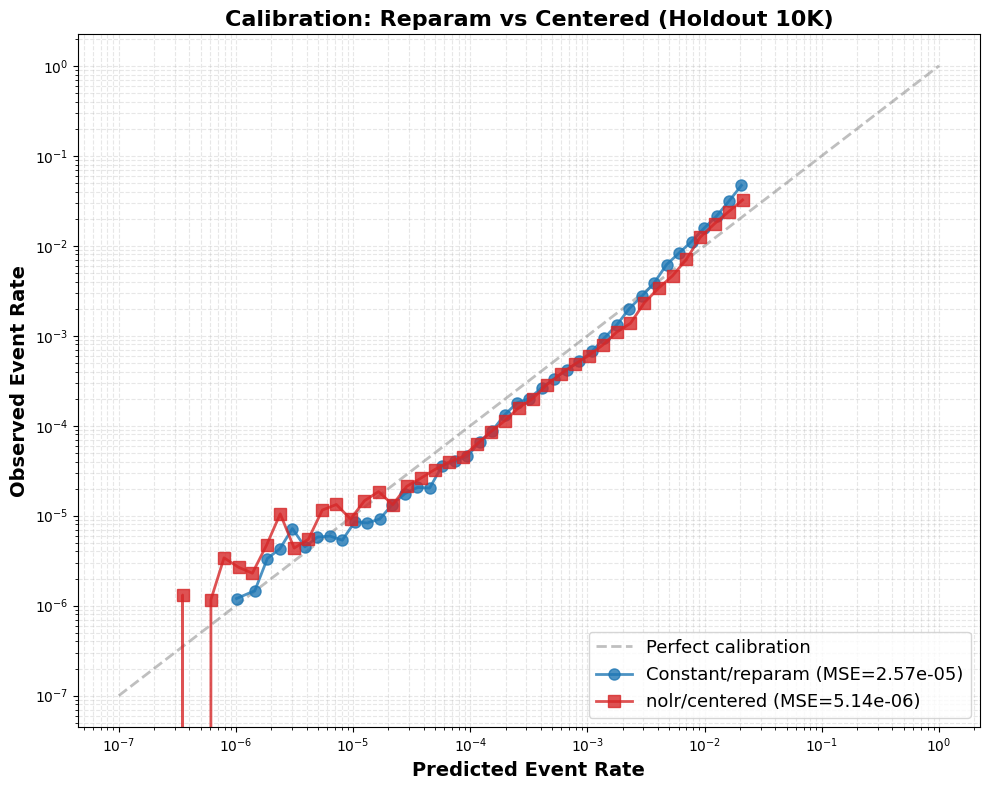

Saved: claudefile/calibration_reparam_vs_centered_holdout.pdf


In [ ]:
# Calibration: constant (reparam) vs nolr (centered) on holdout

# Get pi tensors
pi_const_cal = holdout_results['constant']['pi']
pi_nolr_cal = holdout_results['nolr']['pi']

# Convert to numpy
pi_const_np = pi_const_cal.detach().cpu().numpy() if torch.is_tensor(pi_const_cal) else np.array(pi_const_cal)
pi_nolr_np = pi_nolr_cal.detach().cpu().numpy() if torch.is_tensor(pi_nolr_cal) else np.array(pi_nolr_cal)
Y_np = Y_holdout.detach().cpu().numpy() if torch.is_tensor(Y_holdout) else np.array(Y_holdout)
E_np = E_holdout.detach().cpu().numpy() if torch.is_tensor(E_holdout) else np.array(E_holdout)

N, D, T = Y_np.shape
print(f'Holdout: {N} patients x {D} diseases x {T} timepoints')

# Create at-risk mask: patient n is at risk for disease d at time t if E[n,d] >= t
print('Creating at-risk mask...')
at_risk = np.zeros((N, D, T), dtype=bool)
for n in range(N):
    for d in range(D):
        at_risk[n, d, :] = (E_np[n, d] >= np.arange(T))
print(f'At-risk fraction: {at_risk.mean():.3f}')

def collect_pred_obs(pi_np, Y_np, at_risk, T):
    """Collect predicted and observed values across all at-risk (n, d, t) entries."""
    all_pred, all_obs = [], []
    for t in range(T):
        mask_t = at_risk[:, :, t]
        if mask_t.sum() > 0:
            all_pred.extend(pi_np[:, :, t][mask_t])
            all_obs.extend(Y_np[:, :, t][mask_t])
    return np.array(all_pred), np.array(all_obs)

pred_const, obs_const = collect_pred_obs(pi_const_np, Y_np, at_risk, T)
pred_nolr, obs_nolr = collect_pred_obs(pi_nolr_np, Y_np, at_risk, T)

print(f'Constant: {len(pred_const):,} obs, mean pred={pred_const.mean():.2e}, mean obs={obs_const.mean():.2e}, ratio={pred_const.mean()/obs_const.mean():.3f}')
print(f'nolr:     {len(pred_nolr):,} obs, mean pred={pred_nolr.mean():.2e}, mean obs={obs_nolr.mean():.2e}, ratio={pred_nolr.mean()/obs_nolr.mean():.3f}')

# Compute calibration bins
def compute_calibration_bins(all_pred, all_obs, n_bins=50, min_bin_count=10000):
    bin_edges = np.logspace(np.log10(max(1e-7, all_pred.min())),
                            np.log10(all_pred.max()), n_bins + 1)
    bin_means, obs_means, counts = [], [], []
    for i in range(n_bins):
        mask = (all_pred >= bin_edges[i]) & (all_pred < bin_edges[i + 1])
        if np.sum(mask) >= min_bin_count:
            bin_means.append(np.mean(all_pred[mask]))
            obs_means.append(np.mean(all_obs[mask]))
            counts.append(np.sum(mask))
    return np.array(bin_means), np.array(obs_means), np.array(counts)

bm_const, om_const, ct_const = compute_calibration_bins(pred_const, obs_const)
bm_nolr, om_nolr, ct_nolr = compute_calibration_bins(pred_nolr, obs_nolr)

mse_const = np.mean((bm_const - om_const) ** 2)
mse_nolr = np.mean((bm_nolr - om_nolr) ** 2)

print(f'\nCalibration MSE: constant={mse_const:.2e}, nolr={mse_nolr:.2e}')

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot([1e-7, 1], [1e-7, 1], '--', color='gray', alpha=0.5, label='Perfect calibration', lw=2)
ax.plot(bm_const, om_const, 'o-', color='#1f77b4', ms=8, lw=2,
        label=f'Constant/reparam (MSE={mse_const:.2e})', alpha=0.8)
ax.plot(bm_nolr, om_nolr, 's-', color='#d62728', ms=8, lw=2,
        label=f'nolr/centered (MSE={mse_nolr:.2e})', alpha=0.8)
ax.set_xscale('log'); ax.set_yscale('log')
ax.grid(True, which='both', ls='--', alpha=0.3)
ax.set_xlabel('Predicted Event Rate', fontsize=14, fontweight='bold')
ax.set_ylabel('Observed Event Rate', fontsize=14, fontweight='bold')
ax.set_title('Calibration: Reparam vs Centered (Holdout 10K)', fontsize=16, fontweight='bold')
ax.legend(loc='lower right', fontsize=13)
plt.tight_layout()
plt.savefig('/Users/sarahurbut/aladynoulli2/claudefile/calibration_reparam_vs_centered_holdout.pdf',
            dpi=300, bbox_inches='tight')
plt.show()
print('Saved: claudefile/calibration_reparam_vs_centered_holdout.pdf')